In [173]:
!pip install causalml

In [172]:
# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum

In [174]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

# 업리프트 트리

## make_uplift_classification() 설명

uplift 모델링을 위한 합성(synthetic) 데이터를 생성하는 함수
-> https://github.com/uber/causalml/blob/master/causalml/dataset/classification.py#L171

이진 분류 결과(예: 전환 여부, 구매 여부)를 가지는 uplift 모델링을 위한 가상의 데이터셋을 생성
- treatment_group 여부 (control, treatment1, treatment2, treatment3)
- 19개의 변수(feature)
- conversion 여부 (0, 1)
- treatment_effect = 처치 효과

아래 예시는 공식 예제[Link](https://causalml.readthedocs.io/en/latest/examples/uplift_tree_visualization.html)를 이용했습니다.

In [157]:
# 데이터 생성
df, x_names = make_uplift_classification()

# 변수명 변경
x_names_new = ['feature_%s'%(i) for i in range(len(x_names))]
rename_dict = {x_names[i]:x_names_new[i] for i in range(len(x_names))}
df = df.rename(columns=rename_dict)
x_names = x_names_new

df.head() # 데이터 확인

,treatment_group_key,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,conversion,treatment_effect
0,control,-0.542888,1.976361,-0.531359,-2.354211,-0.380629,-2.614321,-0.128893,0.448689,-2.275192,...,-1.315304,0.742654,1.891699,-2.428395,1.541875,-0.817705,-0.610194,-0.591581,0,0
1,treatment3,0.258654,0.552412,1.434239,-1.422311,0.089131,0.790293,1.159513,1.578868,0.166540,...,-1.391878,-0.623243,2.443972,-2.889253,2.018585,-1.109296,-0.380362,-1.667606,0,0
2,treatment1,1.697012,-2.762600,-0.662874,-1.682340,1.217443,0.837982,1.042981,0.177398,-0.112409,...,-1.132497,1.050179,1.573054,-1.788427,1.341609,-0.749227,-2.091521,-0.471386,0,0
3,treatment2,-1.441644,1.823648,0.789423,-0.295398,0.718509,-0.492993,0.947824,-1.307887,0.123340,...,-2.084619,0.058481,1.369439,0.422538,1.087176,-0.966666,-1.785592,-1.268379,1,1
4,control,-0.625074,3.002388,-0.096288,1.938235,3.392424,-0.465860,-0.919897,-1.072592,-1.331181,...,-1.403984,0.760430,1.917635,-2.347675,1.560946,-0.833067,-1.407884,-0.781343,0,0


In [158]:
# 그룹별 conversion rate 확인
df.pivot_table(values='conversion',
               index='treatment_group_key',
               aggfunc=[np.mean, np.size],
               margins=True)

# 컨트롤 : 51.1%
# 처치1 : 51.4%
# 처치2 : 55.9%
# 처치3 : 60.0%

,mean,size
,conversion,conversion
treatment_group_key,,
control,0.511,1000
treatment1,0.514,1000
treatment2,0.559,1000
treatment3,0.600,1000
All,0.546,4000


In [159]:
# 컨트롤과 처치1 그룹만 분석에 사용
df = df[df['treatment_group_key'].isin(['control','treatment1'])]

# 데이터 셋을 분리해서 모델 학습과 테스트에 이용
df_train, df_test = train_test_split(df, test_size=0.2, random_state=111)

# Train uplift tree
uplift_model = UpliftTreeClassifier(max_depth = 4, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')
uplift_model = UpliftTreeClassifier(control_name='control') # 필수

uplift_model.fit(X = df_train[x_names],
                 treatment=df_train['treatment_group_key'],
                 y=df_train['conversion'])


In [160]:
# Print uplift tree as a string
result = uplift_tree_string(uplift_model.fitted_uplift_tree, x_names)

feature_17 >= -0.44234212654232735?
yes -> feature_10 >= 0.8314747802847717?
		yes -> [np.float64(0.391812865497076), np.float64(0.6181818181818182)]
		no  -> [np.float64(0.5733333333333334), np.float64(0.4492753623188406)]
no  -> feature_9 >= 0.8142773340486676?
		yes -> [np.float64(0.4596774193548387), np.float64(0.61)]
		no  -> [np.float64(0.5379464285714286), np.float64(0.45982142857142855)]


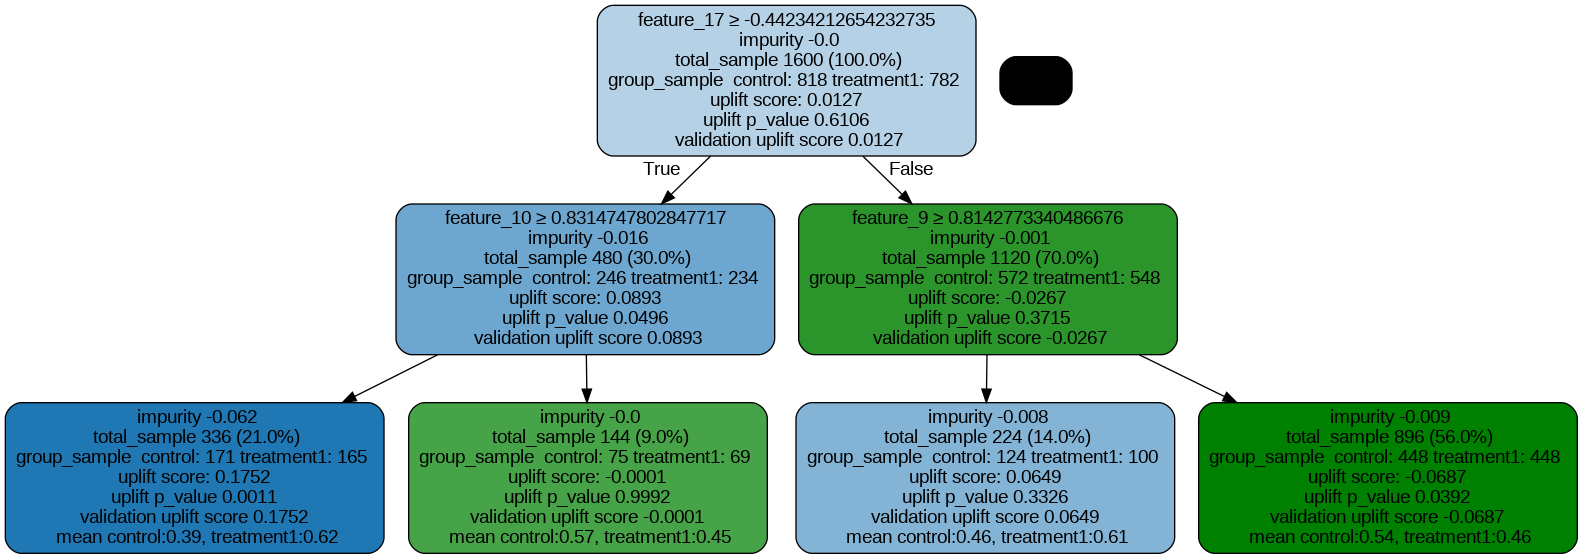

In [161]:
# Plot uplift tree
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,x_names)
Image(graph.create_png())

# 노드 분할 조건 (Node split condition): 노드를 분할하는 데 사용된 규칙 또는 기준 (예: '특징 X > 0.5'와 같은 조건)
# 불순도 (impurity): 손실 함수의 값. 이 값이 낮을수록 노드의 데이터가 더 균일하다는 것을 의미합니다.
# 전체 샘플 수 (total_sample): 현재 노드에 포함된 총 샘플(데이터 포인트)의 개수입니다.
# 그룹별 샘플 수 (group_sample): 각 처리(treatment) 그룹별로 현재 노드에 포함된 샘플의 개수입니다.
##### 업리프트 점수 (uplift score): 처리 그룹과 대조 그룹 간의 처리 효과를 나타내는 값입니다. 여러 개의 처리 그룹이 있는 경우, 이 값은 처리 효과들 중 최댓값을 의미합니다.
# 업리프트 p-값 (uplift p_value): 처리 효과에 대한 통계적 유의미성 p-값입니다. 이 값이 낮을수록 관찰된 처리 효과가 우연일 가능성이 낮다는 것을 나타냅니다.
# 검증 업리프트 점수 (validation uplift score): 트리(모델)에 검증 데이터가 입력되었을 때, 이 검증 데이터를 기반으로 계산된 업리프트 점수입니다.
# 이는 훈련 데이터에 대한 업리프트 점수(uplift score)와 비교하여 과적합(over-fitting) 문제가 있는지 확인할 수 있습니다

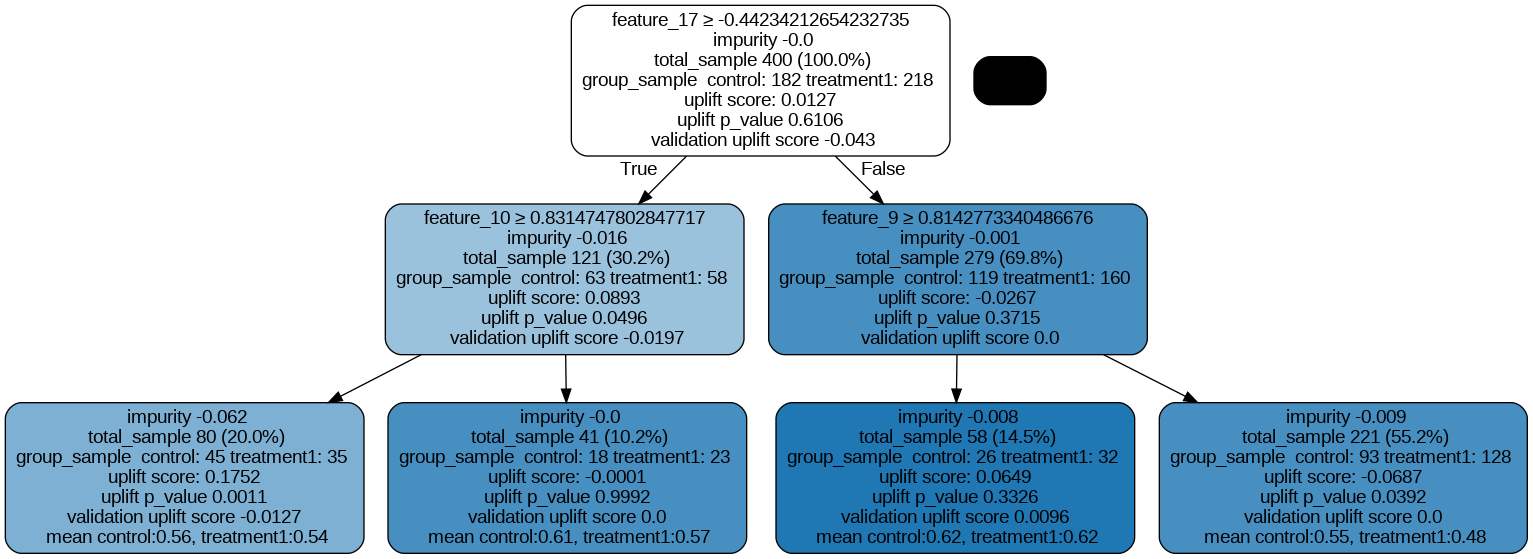

In [162]:
### 테스트 데이터 넣기
# 테스트 데이터 세트를 기반으로 한 향상 점수는 트리 노드의 검증 향상 점수로 표시됩니다.
# predict도 존재합니다. (뒤에서 확인)
uplift_model.fill(X=df_test[x_names],
                  treatment=df_test['treatment_group_key'],
                  y=df_test['conversion']
                  )

# Plot 업리프트 트리
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree,x_names)
Image(graph.create_png())

In [166]:
# predict 확인
ex_data = df_test.query("treatment_group_key == 'control'").query("conversion == 0")

uplift_pred = uplift_model.predict(ex_data[x_names])

uplift_pred[0]
# 이게 무슨뜻일까요?

array([0.5483871, 0.484375 ])

(-0.07681452000000001, 0.65806452)

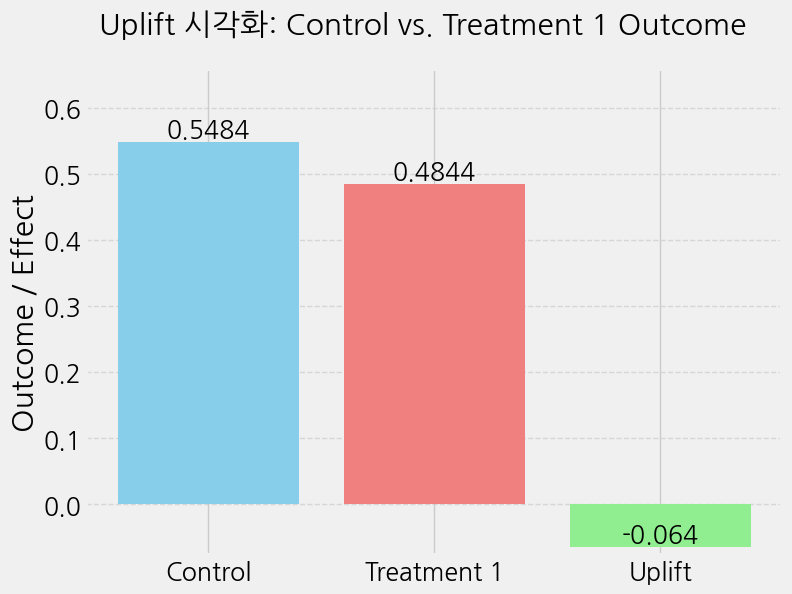

In [164]:
# 'Control' = 0.54 그리고 'Treatment 1' = 0.48 일 때, 결과 확인 방법
control_outcome = 0.5483871
treatment1_outcome = 0.484375

# Calculate uplift (= raw data가 처치를 받으면 1.0 받지 않으면 0.82라는 뜻)
uplift = treatment1_outcome - control_outcome

# 데이터 프레임 생성
data = {
    'Group': ['Control', 'Treatment 1', 'Uplift'],
    'Outcome': [control_outcome, treatment1_outcome, uplift]
}
df = pd.DataFrame(data)

# Define colors for the bars
colors = ['skyblue', 'lightcoral', 'lightgreen']

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(df['Group'], df['Outcome'], color=colors)

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom') # va='bottom' so text is above the bar

# Add labels and title
plt.ylabel('Outcome / Effect')
plt.suptitle('Uplift 시각화: Control vs. Treatment 1 Outcome')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(min(0, uplift * 1.2 if uplift < 0 else 0), max(control_outcome, treatment1_outcome, uplift) * 1.2) # Adjust y-axis limits dynamically

<BarContainer object of 79 artists>

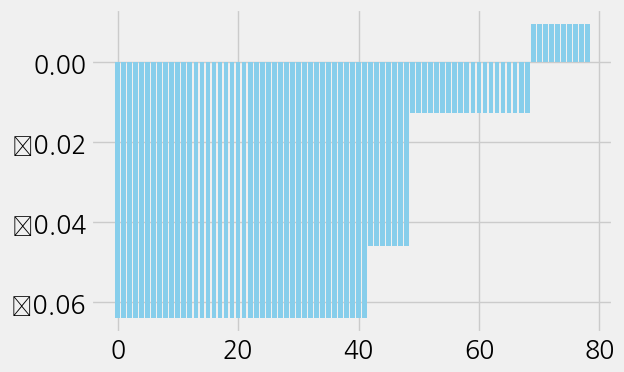

In [130]:
# Uplift=(처치 그룹 결과)−(대조 그룹 결과)
uplift = ( uplift_pred[:, 1]-uplift_pred[:, 0] )
uplift.sort()

# 막대 그래프 그리기
color_map = {'control': 'skyblue', 'treatment1': 'red'}
color_list = [color_map[group] for group in ex_data['treatment_group_key']]

df_test_x_index = [x for x in range(ex_data.shape[0])]
plt.figure(figsize=(6, 4)) # 그래프 크기 설정
plt.bar(df_test_x_index, uplift, color='skyblue') # 막대 그래프 생성

# 컨버젼 = 0

## Forest

In [167]:
uplift_model_forest = UpliftRandomForestClassifier(control_name='control')
uplift_model_forest = UpliftRandomForestClassifier(n_estimators=5, max_depth = 5, min_samples_leaf = 200, min_samples_treatment = 50, n_reg = 100, evaluationFunction='KL', control_name='control')


uplift_model_forest.fit(X = df_train[x_names].values,
                 treatment=df_train['treatment_group_key'].values,
                 y=df_train['conversion'].values)

In [168]:
# Specify a tree in the random forest (the index can be any integer from 0 to n_estimators-1)
uplift_tree = uplift_model_forest.uplift_forest[0]
# Print uplift tree as a string
result = uplift_tree_string(uplift_tree.fitted_uplift_tree, x_names)


feature_0 >= -0.7586003331388741?
yes -> feature_16 >= -0.8722958128000919?
		yes -> [np.float64(0.4463276836158192), np.float64(0.46634615384615385)]
		no  -> feature_6 >= -0.44461520909816576?
				yes -> feature_7 >= 0.1294439907369872?
						yes -> [np.float64(0.5375722543352601), np.float64(0.6357142857142857)]
						no  -> [np.float64(0.4124293785310734), np.float64(0.6544117647058824)]
				no  -> [np.float64(0.40458015267175573), np.float64(0.41304347826086957)]
no  -> [np.float64(0.6047904191616766), np.float64(0.477124183006536)]


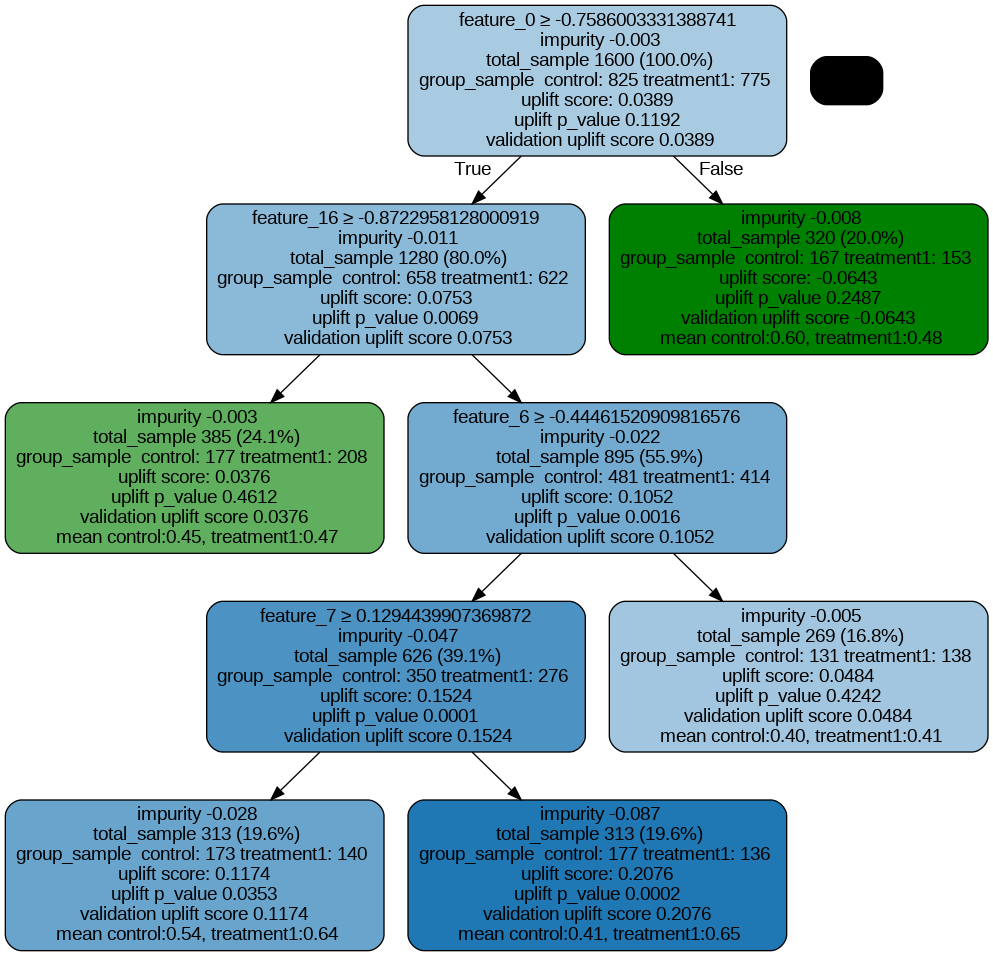

In [169]:
# Plot uplift tree
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,x_names)
Image(graph.create_png())

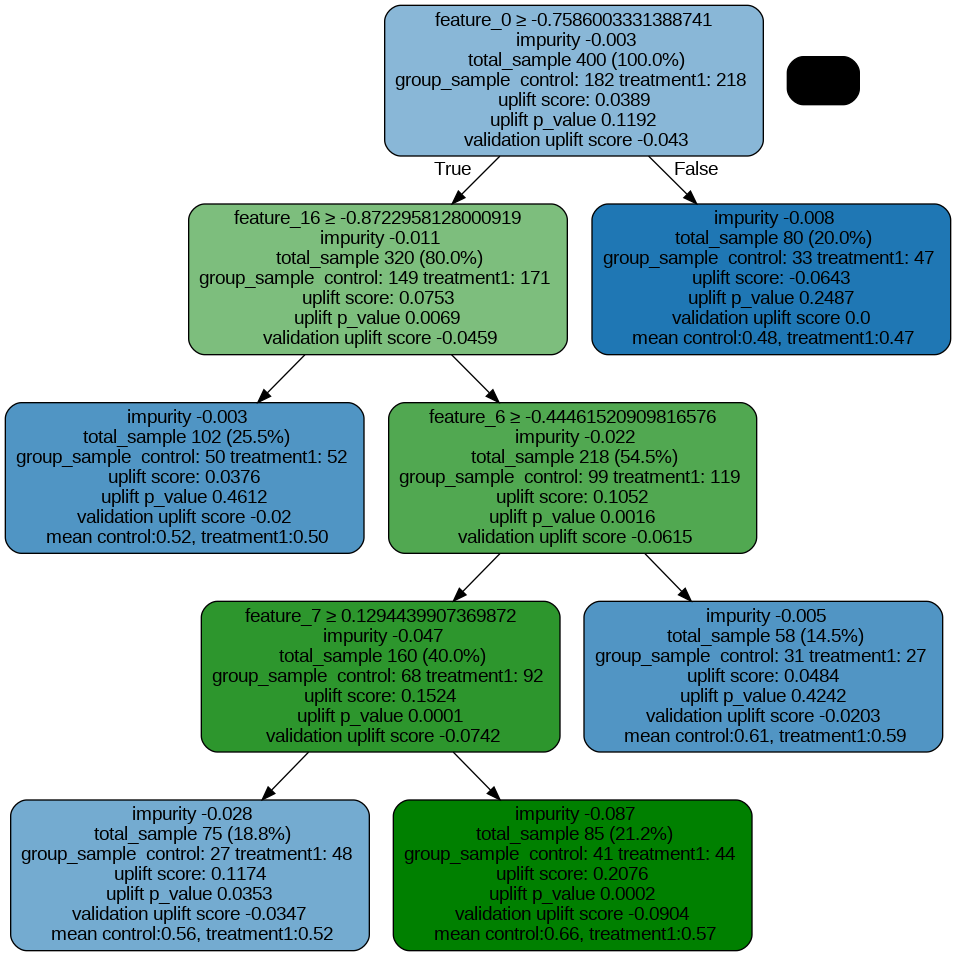

In [170]:
### Fill the trained tree with testing data set
# The uplift score based on testing dataset is shown as validation uplift score in the tree nodes
uplift_tree.fill(X=df_test[x_names], treatment=df_test['treatment_group_key'], y=df_test['conversion'])

# Plot uplift tree
graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree,x_names)
Image(graph.create_png())

In [171]:
# predict 확인
ex_data = df_test.query("treatment_group_key == 'control'").query("conversion == 0")

uplift_pred = uplift_model_forest.predict(ex_data[x_names], full_output = True)

uplift_pred
# 이게 무슨뜻일까요?

,control,treatment1,recommended_treatment,delta_treatment1,max_delta
0,0.486138,0.445226,0,-0.040913,-0.040913
1,0.392328,0.472081,1,0.079753,0.079753
2,0.483065,0.613604,1,0.130539,0.130539
3,0.385649,0.546502,1,0.160854,0.160854
4,0.476878,0.465963,0,-0.010916,-0.010916
...,...,...,...,...,...
74,0.409653,0.503849,1,0.094196,0.094196
75,0.391072,0.485330,1,0.094258,0.094258
76,0.465775,0.482694,1,0.016918,0.016918
77,0.482465,0.477089,0,-0.005375,-0.005375


# Criteo Uplift Prediction Dataset

개인 수준에서 마케팅 개입(광고)의 순수한 효과(Uplift)를 예측하기 위해 고안된 대규모 공개 데이터셋입니다. 마케팅 캠페인의 효율성을 최적화하고, 어떤 사용자에게 어떤 광고를 보여줄 때 가장 긍정적인 반응을 이끌어낼 수 있는지 학습하는 데 활용됩니다.

이 데이터셋은 실제 온라인 광고 캠페인에서 수집된 익명화된 데이터로 구성되어 있습니다.

... GPT 요약



**목적**:

 광고를 보여주었을 때, 구매나 방문 확률이 **증가하는 사용자**를 식별하여, 마케팅 예산을 효율적으로 배분하기

**데이터셋 구성**

**사용자 특성(Features):**

`f0`부터 `f11`까지의 총 12개 변수로, 사용자의 행동 패턴이나 인구통계학적 정보 등을 익명화하여 나타냅니다. 이 특징들은 주로 범주형(categorical) 또는 이산형(discrete)입니다.

---

**처치 여부(Treatment Indicator):**

treatment 칼럼으로, 사용자가 광고를 보았는지(Treatment) 아니면 **광고를 보지 않았는지(Control)**를 나타냅니다.

1: 처치 그룹 (광고 노출)

0: 대조 그룹 (광고 미노출)

---
**결과 변수(Outcome Variables):**

conversion: 사용자가 광고를 본 후 구매 또는 전환 행동을 했는지를 나타냅니다 (1은 전환, 0은 미전환). 이것이 주요 예측 목표 중 하나입니다.

visit: 사용자가 광고를 본 후 사이트를 방문했는지를 나타냅니다 (1은 방문, 0은 미방문). 이 역시 중요한 결과 지표입니다.

In [ ]:
# 목적에 맞춰서 분석 보고서를 작성하기
##


In [208]:
import pandas as pd

df = pd.read_csv("hf://datasets/criteo/criteo-uplift/criteo-research-uplift-v2.1.csv.gz")

In [209]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
